# Explore data from Digital Language Death

Status: 2012

Paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077056  
Data: http://hlt.sztaki.hu/resources/  
Data description: http://hlt.sztaki.hu/resources/dld-header.pdf  
Online version: https://hlt.bme.hu/en/dld/  

## Output

- index: lang code
- for all European languages
- status of endangerment
- availability of digital tools


## TODO

- what is Crúbabán?
- save output
- outlier-handling

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score

## Read Digital Language Death (DLD) data

In [2]:
dld = pd.read_csv("../../data/digital/dld_joined.tsv", sep="\t", skiprows=2)

/home/eszter/.pyenv/versions/3.9.6/envs/phd/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,74,77,85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
for i, col in enumerate(dld.columns):
    print(f"{i}\t{col}")

0	unique_join_code
1	la_Other resources in the language_All
2	la_Other resources about the language_Online
3	Comments
4	MS-if-pack
5	la_Other resources in the language_Online
6	hunspell status
7	cru2_Alternate names
8	character entropy*
9	la_Resources in the language_Online
10	cru1_UDHR
11	la_Lexical resources_Online
12	cru2_Polluters
13	cru2_SIL
14	cru2_Updated
15	sample_result
16	articles
17	cru2_Code
18	la_Language descriptions_Online
19	adjusted WP size
20	cru2_Contact(s)
21	cru2_FLOSS SplChk
22	cru2_ISO-639-3
23	MAC-input
24	la_Primary texts_Online
25	WP_incubator
26	cru2_Classification
27	cru2_WT
28	cru2_WP
29	Print_Name
30	cru1_WP
31	cru1_SIL
32	cru1_WT
33	cru1_Contact(s)
34	avg good page length
35	language (local)
36	cru1_Words
37	WP_incubator_new
38	cru2_Docs
39	WP size in chars
40	TLD backup
41	language
42	cru2_Words
43	Seed
44	la_Resources in the language_All
45	cru1_Alternate names
46	Eth_Language Status
47	la_Lexical resources_All
48	cru2_Close to
49	cru1_ISO-639-3
50	Inve

In [4]:
pd.unique(dld["cru1_ISO-639-3"].values.ravel())

array(['0', 'xtd', 'xtn', ..., 'myu', 'myv', 'mya'], dtype=object)

In [5]:
display(dld)

,unique_join_code,la_Other resources in the language_All,la_Other resources about the language_Online,Comments,MS-if-pack,la_Other resources in the language_Online,hunspell status,cru2_Alternate names,character entropy*,la_Resources in the language_Online,...,TLDs(%),cru1_Name (English),L2,L1,MS-pack,la_Other resources about the language_All,cru2_Country,end_class,real/ total ratio,Id
0,xxe-nik-mil,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,7,0.0,0
1,xtw,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,8,0.0,xtw
2,xtv,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,xtv
3,xtu,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,1880,0,0,0,0,0.0,xtu
4,xtt,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,390,0,0,0,0,0.0,xtt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8421,myd,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,840,0,0,0,0,0.0,myd
8422,myg,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,5300,0,0,0,0,0.0,myg
8423,myf,0,4,0,0.0,0,0,0,0.0,0,...,0,0,0,5000,0,5,0,6,0.0,myf
8424,bcx,0,0,0,0.0,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0.0,0


### Filter columns of interest

In [6]:
# Ids & Names
PRINT_NAME = "Print_Name" # standardized English language name
LANG_LOC = "language (local)" # the local name of the language
SIL = "SIL code" # SIL code

# Endangerment status
ETHN = "Eth_Language Status" # the EGIDS status of the language according to the Ethnologue.
ELP = "end_class" # classification according to the Endangered Languages Project (the higher, the more endangered)

# Speakers
L1 = "L1" # number of people speaking the language natively (L1 speakers)
L2 = "L2" # number of people speaking the language as second language (L2 speakers)

# Wikipedia
WP_NAME = "wikiname" # the two-letter (sometimes longer) code used in Wikipedia
WP_ART = "articles" # number of articles in wikipedia (2012 May)
WP_SIZE_ADJ = "adjusted WP size" # character count of ‘real’ wikipedia pages
WP_SIZE_CH = "WP size in chars" # raw (unadjusted) character count of wikipedia
WP_INCUB = "WP_incubator_new" # whether Wikipedia had an incubator for the language in March 2013
WP_AVG_LEN = "avg good page length" # average length of ‘real’ wikipedia pages
WP_REAL_TOT = "real/ total ratio" #  proportion of ‘real’ and 'total' wikipedia pages

# Windows
MS_IN = "MS-if-pack" # Microsoft input-level support
MS_OS = "MS-pack" # OS-level support in Windows 7

# MAC
MAC_IN = "MAC-input" # input-level support by Apple
MAC_OS = "MAC-supp" # OS-level support in MacOS 10.6.8

# Spellchecker
HUN_STAT = "hunspell status" # whether a hunspell checker exists
HUN_COV = "hunspell coverage" # the percentage coverage Hunspell has on the wikipedia dump

# Crúbadán
CR1_ID = "cru1_ISO-639-3" # iso-code from first Crúbadán summary
CR2_ID = "cru2_ISO-639-3" # iso-code from second Crúbadán summary

CR1_CH = "cru1_Characters" # number of characters found by the first Crúbadán crawl
CR2_CH = "cru2_Characters" # number of characters found by the second Crúbadán crawl

CR1_WORDS = "cru1_Words" # number of words found by the first Crúbadán crawl
CR2_WORDS = "cru2_Words" # number of words found by the second Crúbadán crawl

CR1_DOCS = "cru1_Docs" # number of documents found by the first Crúbadán crawl
CR2_DOCS = "cru2_Docs" # number of documents found by the second Crúbadán crawl

CR1_UDHR = "cru1_UDHR" # translation of the Universal Declaration of Human rights exists according to the first Crúbadán summary
CR2_UDHR = "cru2_UDHR" # translation of the Universal Declaration of Human rights exists according to the second Crúbadán summary

CR1_FLOSS = "cru1_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the first Crúbadán summary
CR2_FLOSS = "cru2_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the second Crúbadán summary

CR1_BIB = "cru1_WT" # whether an online Bible exists at watchtower.org according to the first Crúbadán summary
CR2_BIB = "cru2_WT" # whether an online Bible exists at watchtower.org according to the second Crúbadán summary

# Other
TLD = "TLDs(%)" # whether a national level Top Level Domain (not .com, .org, .edu) appeared in the top three domains that the crawl found language data in
OLAC = "la_Primary texts_Online" # the number of OLAC primary texts online

In [7]:
dld_fil = dld[[
    # Ids & names
    PRINT_NAME,
    LANG_LOC,
    SIL,    
    
    # Endangerment status
    ETHN,
    ELP,
    
    # Speakers
    L1,
    L2,
    
    # Wikipedia
    WP_NAME,
    WP_ART,
    WP_SIZE_ADJ,
    WP_SIZE_CH,
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    
    # Windows
    MS_IN,
    MS_OS,
    
    # MAC
    MAC_IN,
    MAC_OS,
    
    # Spellchecker
    HUN_STAT,
    HUN_COV,
    
    # Crúbadán
    CR1_ID,
    CR2_ID,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    
    # Other
    TLD,
    OLAC
]]

In [8]:
dld_fil.loc[dld_fil[CR1_ID] != dld_fil[CR2_ID]][[CR1_ID, CR2_ID]]

,cru1_ISO-639-3,cru2_ISO-639-3
44,0,xxx-pi-Latn
47,0,txu
59,0,daf
75,0,jmc
126,0,mda
...,...,...
8362,0,ndz
8385,0,var
8392,0,bch
8400,0,myy


## Read European languages data

In [9]:
LANG_ID = "LangID"

In [10]:
eur_lang = pd.read_csv("../../data/european_languages.csv")

In [11]:
eur_lang

,LangID,CountryID,LangStatus,Name_lang,Name_country,Area
0,aae,IT,L,"Albanian, Arbëreshë",Italy,Europe
1,cim,IT,L,Cimbrian,Italy,Europe
2,egl,IT,L,Emilian,Italy,Europe
3,fur,IT,L,Friulian,Italy,Europe
4,ils,IT,L,International Sign,Italy,Europe
...,...,...,...,...,...,...
288,vgt,BE,L,Flemish Sign Language,Belgium,Europe
289,vls,BE,L,West Flemish,Belgium,Europe
290,wln,BE,L,Walloon,Belgium,Europe
291,slv,SI,L,Slovene,Slovenia,Europe


## Merge DLD with European languages

In [12]:
print(dld_fil.shape)
print(eur_lang.shape)

(8426, 36)
(293, 6)


In [13]:
eur_dld = eur_lang.join(dld_fil.set_index(CR2_ID), on="LangID", how="inner")
print(eur_dld.shape)

(138, 41)


## Clean data

In [14]:
eur_dld[[L1, PRINT_NAME, SIL, WP_INCUB, MAC_IN, MAC_OS, MS_IN, MS_OS, HUN_STAT, CR1_CH, CR1_FLOSS, CR1_UDHR, CR2_UDHR, CR1_BIB, OLAC]]

,L1,Print_Name,SIL code,WP_incubator_new,MAC-input,MAC-supp,MS-if-pack,MS-pack,hunspell status,cru1_Characters,cru1_FLOSS SplChk,cru1_UDHR,cru2_UDHR,cru1_WT,la_Primary texts_Online
0,100000,Arbëreshë Albanian,0,0,0,0,0.0,0,0,1409,no,-,-,-,0
3,300000,Friulian,fur,0,0,FALSE,NaN,0,myspell,112024108,yes,frl,frl,-,0
6,61068677,Italian,ita,0,1,TRUE,0.0,F,aff-dic,47899709,yes,itn,itn,i,22
8,505100,Ligurian,lij,0,0,FALSE,0.0,0,not found,1055103,no,-,-,-,0
9,20000,Ladin,0,1,0,0,0.0,0,0,4713798,no,-,-,rh,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,540780,Vlax Romani,0,0,0,0,0.0,0,0,888577,no,rmy1,rmy1,-,0
286,23623890,Romanian,ron,0,1,FALSE,0.0,0,not found,43662167,yes,rum,rum,m,6
289,1204000,Vlaams,vls,0,0,FALSE,0.0,0,not found,1495667,no,-,-,-,1
290,600000,Walloon,wln,0,0,FALSE,0.0,0,aff-dic,13538741,yes,frn1,frn1,-,0


In [15]:
eur_dld_clean = eur_dld.copy()

In [16]:
# L1 is interpreted as object -> convert to int
eur_dld_clean[L1] = eur_dld[L1].astype(int)

In [17]:
# MAC OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_mac(x):
    if x == "TRUE":
        return 1
    return 0

eur_dld_clean[MAC_OS] = eur_dld[MAC_OS].apply(lambda x: apply_mac(x))

In [18]:
# Microsoft OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_win(x):
    if x == "P" or x == "F":
        return 1
    return 0

eur_dld_clean[MS_OS] = eur_dld[MS_OS].apply(lambda x: apply_win(x))

In [19]:
# UDHR and Bible availability is given textual -> convert it to 0/1 (if there's any it's 1)
def true_id_not_empty(x):
    if x == "-":
        return 0
    return 1

eur_dld_clean[CR1_UDHR] = eur_dld[CR1_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_UDHR] = eur_dld[CR2_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR1_BIB] = eur_dld[CR1_BIB].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_BIB] = eur_dld[CR2_BIB].apply(lambda x: true_id_not_empty(x))

In [20]:
# FLOSS availability is given textual -> convert it to 0/1 (no data is also 0)
def apply_floss(x):
    if x == "yes":
        return 1
    return 0

eur_dld_clean[CR1_FLOSS] = eur_dld[CR1_FLOSS].apply(lambda x: apply_floss(x))
eur_dld_clean[CR2_FLOSS] = eur_dld[CR2_FLOSS].apply(lambda x: apply_floss(x))

In [21]:
missing = eur_dld.columns[eur_dld.isnull().any()]
print(missing)

Index(['MS-if-pack', 'hunspell coverage'], dtype='object')


In [22]:
pd.unique(eur_dld[MS_IN].values.ravel())

array([ 0., nan,  1.])

In [23]:
pd.unique(eur_dld[HUN_COV].values.ravel())

array([0.  , 0.79, 0.8 ,  nan, 0.82, 0.59, 0.73, 0.84, 0.77, 0.81, 0.74,
       0.71, 0.85, 0.66, 0.75, 0.33, 0.65, 0.18, 0.63, 0.83, 0.7 , 0.54,
       0.44, 0.72])

In [24]:
# Fill NaN with 0
eur_dld_clean[MS_IN] = eur_dld[MS_IN].fillna(0)
eur_dld_clean[HUN_COV] = eur_dld[HUN_COV].fillna(0)

In [25]:
missing = eur_dld_clean.columns[eur_dld_clean.isnull().any()]
print(missing)

Index([], dtype='object')


In [26]:
eur_dld.dtypes

LangID                      object
CountryID                   object
LangStatus                  object
Name_lang                   object
Name_country                object
Area                        object
Print_Name                  object
language (local)            object
SIL code                    object
Eth_Language Status        float64
end_class                    int64
L1                          object
L2                           int64
wikiname                    object
articles                     int64
adjusted WP size           float64
WP size in chars             int64
WP_incubator_new             int64
avg good page length       float64
real/ total ratio          float64
MS-if-pack                 float64
MS-pack                     object
MAC-input                    int64
MAC-supp                    object
hunspell status             object
hunspell coverage          float64
cru1_ISO-639-3              object
cru1_Characters              int64
cru2_Characters     

In [27]:
eur_dld_clean.dtypes

LangID                      object
CountryID                   object
LangStatus                  object
Name_lang                   object
Name_country                object
Area                        object
Print_Name                  object
language (local)            object
SIL code                    object
Eth_Language Status        float64
end_class                    int64
L1                           int64
L2                           int64
wikiname                    object
articles                     int64
adjusted WP size           float64
WP size in chars             int64
WP_incubator_new             int64
avg good page length       float64
real/ total ratio          float64
MS-if-pack                 float64
MS-pack                      int64
MAC-input                    int64
MAC-supp                     int64
hunspell status             object
hunspell coverage          float64
cru1_ISO-639-3              object
cru1_Characters              int64
cru2_Characters     

## Investigate correlation

In [28]:
NUM_COLS = [
    L1,
    L2,
    WP_ART,
    WP_SIZE_ADJ, 
    WP_SIZE_CH, 
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    MS_OS,
    MS_IN,
    MAC_OS,
    MAC_IN,
    HUN_COV,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    OLAC
]

STATUS_COLS = [
    ETHN,
    ELP,
]

print(len(NUM_COLS + STATUS_COLS))

28


In [29]:
eur_dld_clean[NUM_COLS]

,L1,L2,articles,adjusted WP size,WP size in chars,WP_incubator_new,avg good page length,real/ total ratio,MS-pack,MS-if-pack,...,cru2_Words,cru1_Docs,cru2_Docs,cru1_UDHR,cru2_UDHR,cru1_FLOSS SplChk,cru2_FLOSS SplChk,cru1_WT,cru2_WT,la_Primary texts_Online
0,100000,0,0,0.000000e+00,0,0,0.000000,0.000000,0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,300000,0,3005,1.587449e+06,2651256,0,2470.000000,0.190000,0,0.0,...,0,8926,0,1,1,1,1,0,0,0
6,61068677,0,925588,1.429840e+09,1970376775,0,5402.000000,0.300000,1,0.0,...,0,1212,0,1,1,1,1,1,1,22
8,505100,0,2898,5.411670e+05,1316050,0,2840.000000,0.070000,0,0.0,...,0,40,0,0,0,0,0,0,0,0
9,20000,0,117,1.857410e+05,222896,1,6404.862069,0.247863,0,0.0,...,0,399,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,540780,0,0,0.000000e+00,0,0,0.000000,0.000000,0,0.0,...,0,24,0,1,1,0,0,0,0,0
286,23623890,0,401,2.064830e+05,318298,0,4482.000000,0.110000,0,0.0,...,0,1542,0,1,1,1,1,1,1,6
289,1204000,0,4446,2.261504e+06,5635616,0,3042.000000,0.180000,0,0.0,...,0,187,0,0,0,0,0,0,0,1
290,600000,0,12399,1.602744e+06,6006985,0,4146.000000,0.030000,0,0.0,...,0,624,0,1,1,1,1,0,0,0


### Correlation matrix of numerical values

<AxesSubplot:title={'center':'Correlation between numeric variables'}>

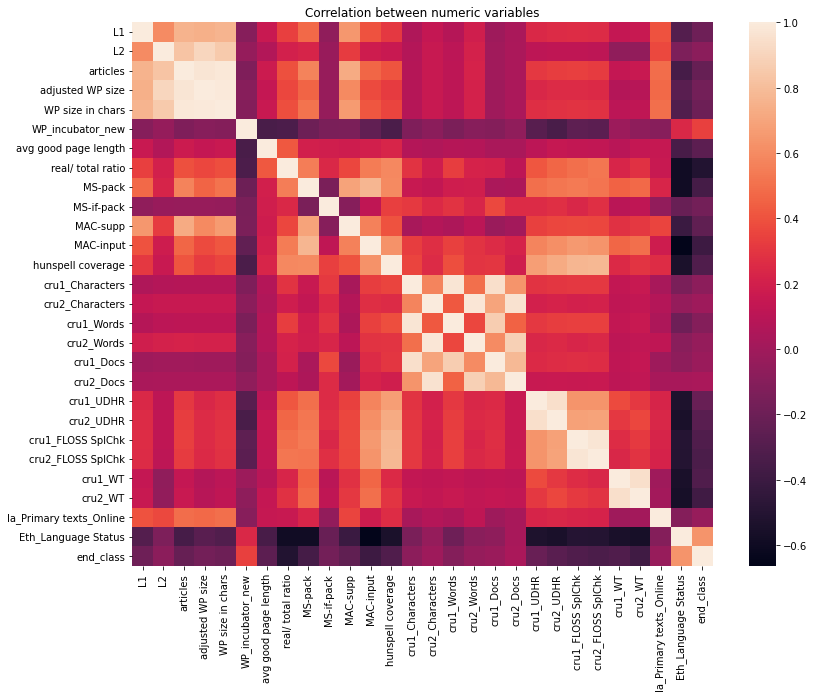

In [30]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation between numeric variables")
corr = eur_dld_clean[NUM_COLS + STATUS_COLS].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

from sklearn.metrics import explained_variance_scoref Ethnologue

,Eth_Language Status
MAC-input,-0.663741
real/ total ratio,-0.590073
MS-pack,-0.587607
cru2_WT,-0.566121
cru1_WT,-0.548833
cru2_UDHR,-0.546941
hunspell coverage,-0.544136
cru1_UDHR,-0.529287
cru2_FLOSS SplChk,-0.502468
cru1_FLOSS SplChk,-0.495520


<AxesSubplot:title={'center':'Correlation with degree and availability of digital tools'}>

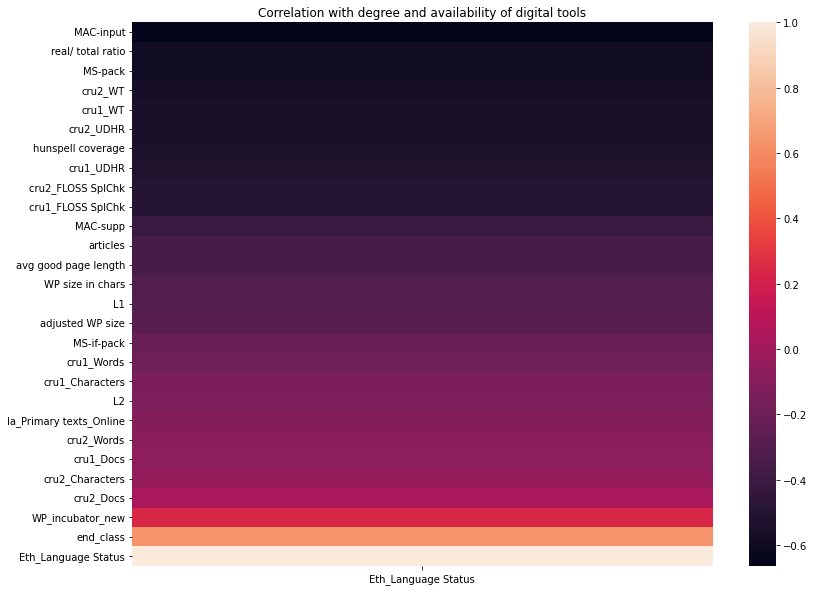

In [31]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation with degree and availability of digital tools")

corr_ethn = corr[[ETHN]].sort_values(by=ETHN)
display(corr_ethn)
sns.heatmap(corr_ethn, 
        xticklabels=corr_ethn.columns,
        yticklabels=corr_ethn.index)

### Correlation with endangerment status of Endangered Languages Project

,end_class
real/ total ratio,-0.511743
MAC-input,-0.392277
cru2_WT,-0.383776
MS-pack,-0.363299
cru2_FLOSS SplChk,-0.337651
cru1_WT,-0.318492
hunspell coverage,-0.316481
cru1_FLOSS SplChk,-0.315345
cru2_UDHR,-0.280258
avg good page length,-0.264487


<AxesSubplot:title={'center':'Correlation with degree and availability of digital tools'}>

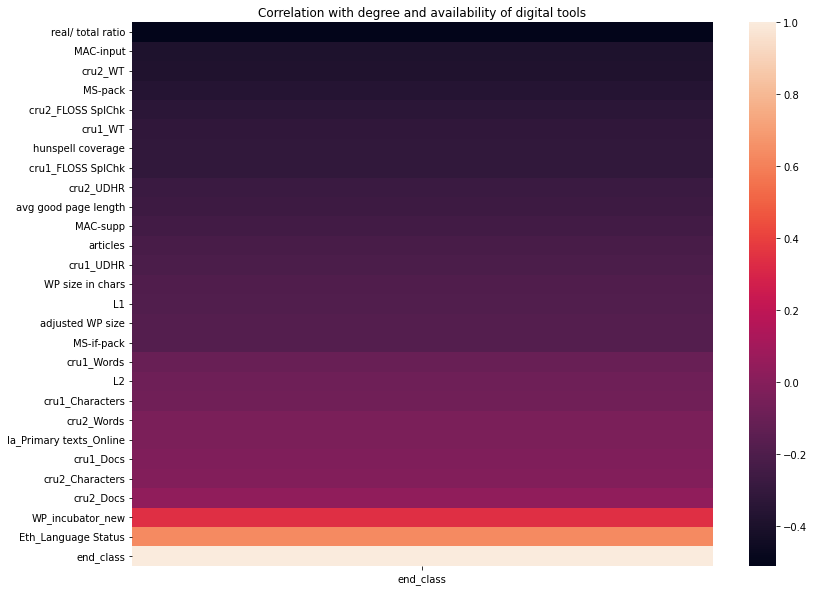

In [32]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation with degree and availability of digital tools")

corr_elp = corr[[ELP]].sort_values(by=ELP)
display(corr_elp)
sns.heatmap(corr_elp, 
        xticklabels=corr_elp.columns,
        yticklabels=corr_elp.index)

## Fit model to find out most important factors

In [33]:
def create_dataset(data, label_to_predict, test_size=0.2, random_state=0):
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)

    y = train[label_to_predict]
    y_true = test[label_to_predict]

    del train[label_to_predict]
    del test[label_to_predict]
    return train, test, y, y_true

def print_pred(y_true, y_pred, title):
    df = pd.DataFrame()
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df.sort_index().plot(y=["y_true", "y_pred"], figsize=(22, 10), title=title, kind="bar")
    
def print_coefs(cols, coefs):
    df = pd.DataFrame()
    df["Features"] = cols
    df["coefs"] = abs(coefs)
    display(df.sort_values(by="coefs", ascending=False))
    
def print_score(y_true, y_pred, method):
    print(method(y_true, y_pred))

def fit(scaler, model, train, y, test, y_true, coefs=False, title=None):
    reg = make_pipeline(scaler, model)
    reg.fit(train, y)
    y_pred = reg.predict(test)
    print_score(y_true, y_pred, explained_variance_score)
    if coefs:
        print_coefs(train.columns, model.coef_)
    if title:
        print_pred(y_true, y_pred, title)
    return y_pred

### Create dataset

#### Predict Ethnologue status based on digitalization factors.

In [34]:
data = eur_dld_clean[NUM_COLS + [ETHN, LANG_ID]]
data.set_index("LangID", inplace=True)
train, test, y, y_true = create_dataset(data, ETHN, test_size=0.2, random_state=0)
print(train.shape)
print(test.shape)

(110, 26)
(28, 26)


-4.3965354501857705


,Features,coefs
10,MAC-supp,5.072919e+08
11,MAC-input,2.110703e+08
8,MS-pack,1.708168e+08
9,MS-if-pack,3.701979e+07
21,cru1_FLOSS SplChk,1.334710e+07
12,hunspell coverage,1.227116e+07
7,real/ total ratio,8.289368e+06
22,cru2_FLOSS SplChk,7.480005e+06
20,cru2_UDHR,2.953604e+05
23,cru1_WT,1.933459e+05


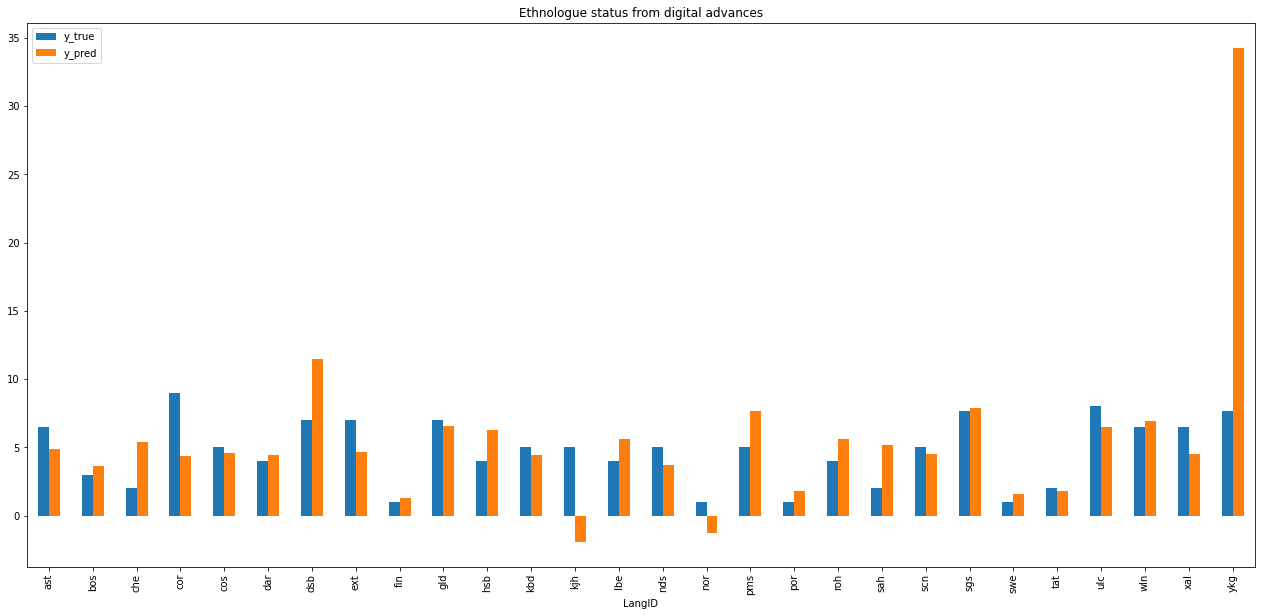

In [35]:
lr = LinearRegression()
y_pred_lr = fit(Normalizer(), lr, train, y, test, y_true, coefs=True, title="Ethnologue status from digital advances")

In [36]:
data.loc["ykg"]

L1                             0.0
L2                             0.0
articles                       0.0
adjusted WP size               0.0
WP size in chars               0.0
WP_incubator_new               0.0
avg good page length           0.0
real/ total ratio              0.0
MS-pack                        0.0
MS-if-pack                     0.0
MAC-supp                       0.0
MAC-input                      0.0
hunspell coverage              0.0
cru1_Characters            15841.0
cru2_Characters                0.0
cru1_Words                  1686.0
cru2_Words                     0.0
cru1_Docs                      2.0
cru2_Docs                      0.0
cru1_UDHR                      1.0
cru2_UDHR                      1.0
cru1_FLOSS SplChk              0.0
cru2_FLOSS SplChk              0.0
cru1_WT                        0.0
cru2_WT                        0.0
la_Primary texts_Online        0.0
Eth_Language Status            7.7
Name: ykg, dtype: float64

In [37]:
data.loc["nor"]

L1                          4741780.0
L2                                0.0
articles                          0.0
adjusted WP size                  0.0
WP size in chars                  0.0
WP_incubator_new                  0.0
avg good page length              0.0
real/ total ratio                 0.0
MS-pack                           0.0
MS-if-pack                        0.0
MAC-supp                          0.0
MAC-input                         1.0
hunspell coverage                 0.0
cru1_Characters            29491194.0
cru2_Characters                   0.0
cru1_Words                  4498017.0
cru2_Words                        0.0
cru1_Docs                      2001.0
cru2_Docs                         0.0
cru1_UDHR                         0.0
cru2_UDHR                         0.0
cru1_FLOSS SplChk                 1.0
cru2_FLOSS SplChk                 1.0
cru1_WT                           0.0
cru2_WT                           0.0
la_Primary texts_Online           4.0
Eth_Language

#### Predict Endangered Languages Project status based on digitalization factors.

In [38]:
data = eur_dld_clean[NUM_COLS + [ELP, LANG_ID]]
data.set_index(LANG_ID, inplace=True)
train, test, y, y_true = create_dataset(data, ELP, test_size=0.2, random_state=0)
print(train.shape)
print(test.shape)

(110, 26)
(28, 26)


-46.90485883048542


,Features,coefs
11,MAC-input,1.528966e+08
10,MAC-supp,4.238205e+07
22,cru2_FLOSS SplChk,3.674200e+07
21,cru1_FLOSS SplChk,3.595636e+07
9,MS-if-pack,2.576131e+07
8,MS-pack,7.571580e+06
12,hunspell coverage,7.187097e+06
7,real/ total ratio,2.772680e+06
20,cru2_UDHR,1.580944e+06
24,cru2_WT,7.615483e+05


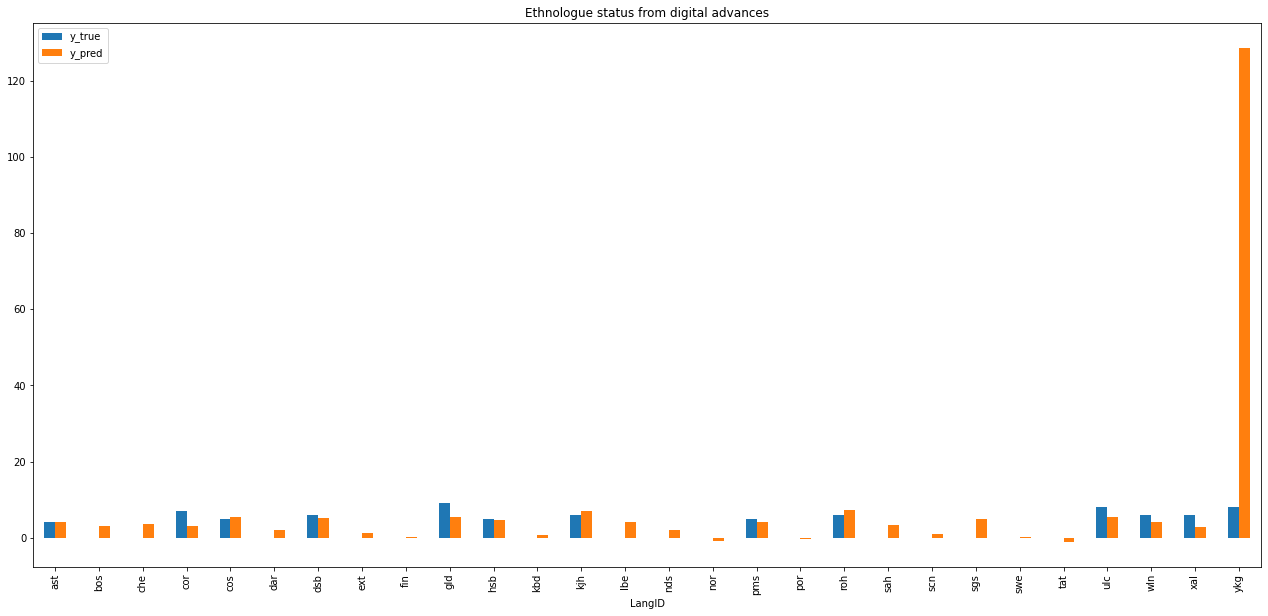

In [39]:
lr = LinearRegression()
y_pred_lr = fit(Normalizer(), lr, train, y, test, y_true, coefs=True, title="Ethnologue status from digital advances")

## Conclusion

Most important digital factors for determining endangerment status (for both metrics):

- MAC and Windows OS level & input support
- The existence of a spellchecker and their word coverage.
- Ratio of real/total wikipedia pages.
- Availability of Bible and Universal Declaration of Human rights translations


Not so important featrues (for both metrics):

- Number of speakers.
- Character size of available resources.